# GTSRB - Feed Forward Neural Net

## Imports

In [12]:
%matplotlib notebook

from src.data import BatchServer, utils

import math
from datetime import datetime

import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

## Defining constants

In [13]:
dataset_train = "../data/gtsrb-train.tfrecords"
dataset_test = "../data/gtsrb-test.tfrecords"

learning_rate = 0.001
batch_size = 128
epochs = 10

## Building the graph

In [14]:
# Create input and output placeholders
X = tf.placeholder(tf.float32, [None, 40 * 40 * 3], "X")
Y = tf.placeholder(tf.float32, [None, 43], "Y")

# Initialize weights
w_h1 = tf.Variable(tf.random_normal([40 * 40 * 3, 100], stddev=0.01), name="w_h1")  # Layer 1
w_h2 = tf.Variable(tf.random_normal([100, 100], stddev=0.01), name="w_h2")  # Layer 2
w_h3 = tf.Variable(tf.random_normal([100, 100], stddev=0.01), name="w_h3")  # Layer 3
w_h4 = tf.Variable(tf.random_normal([100, 100], stddev=0.01), name="w_h4")  # Layer 4
w_o = tf.Variable(tf.random_normal([100, 43], stddev=0.01), name="w_o")  # Output layer

# Define model
with tf.name_scope("hidden_1"):
    X = tf.nn.dropout(X, 0.5)
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
with tf.name_scope("hidden_2"):
    h1 = tf.nn.dropout(h1, 0.5)
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
with tf.name_scope("hidden_3"):
   h2 = tf.nn.dropout(h2, 0.5)
   h3 = tf.nn.relu(tf.matmul(h2, w_h3))
with tf.name_scope("hidden_4"):
    h3 = tf.nn.dropout(h3, 0.5)
    h4 = tf.nn.relu(tf.matmul(h3, w_h4))
with tf.name_scope("output"):
    h4 = tf.nn.dropout(h4, 0.5)
    p_y = tf.nn.softmax(tf.matmul(h4, w_o))

Next we define the cost and accuracy functions and also the train operation

In [15]:
# Define cost function
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=p_y, labels=Y))
    # Define train operation
    train = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
    # Add summary to cost tensor
    tf.summary.scalar("cost", cost)

# Accuracy function
with tf.name_scope("accuracy"):
    #  Count correct predictions
    correct_pred = tf.equal(tf.argmax(p_y, 1), tf.argmax(Y, 1))
    # Calculate average accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

## Running the graph

We set the batchsize of the test batch server to the number of test records because we want to get all test examples at once to calculate the test error over the whole test set.

In [16]:
# Calculate number of records in dataset
num_train_records = utils.get_number_of_records(dataset_train)
num_test_records = utils.get_number_of_records(dataset_test)

# Read input data
train_data = BatchServer(dataset_train, 40 * 40 * 3, 43, tf.uint8, batch_size)
test_data = BatchServer(dataset_test, 40 * 40 * 3, 43, tf.uint8, num_test_records)

print("Train Set: {} Examples".format(num_train_records))
print("Test Set: {} Examples".format(num_test_records))

Train Set: 16866 Examples
Test Set: 2912 Examples


In [17]:
with tf.Session() as sess:

    # Initialize variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    # Create training coordinator
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    print("Training...")
    
    # Store train accuracies in array
    accuracies_train = {}
    # Store test accuracies in dict
    accuracies_test = {}
    
    for i in range(epochs):
               
        iterations_per_epoch = math.floor(num_train_records / batch_size)
    
        for j in range(iterations_per_epoch):
            # Get next batch of images and labels
            train_batch_images, train_batch_labels = sess.run(train_data.next_batch())
            
            # Run training
            sess.run(train, feed_dict={X: train_batch_images, Y: train_batch_labels})

            # Calculate accuracy
            train_accuracy = sess.run(accuracy, feed_dict={X: train_batch_images, Y: train_batch_labels})
            
            accuracies_train[i * iterations_per_epoch + j] = train_accuracy
                        
            # Calculate test accuracy 10 times per epoch
            if j % int(iterations_per_epoch * 0.5) == 0:
                
                # Calculate test accuracy once per epoch
                test_batch_images, test_batch_labels = sess.run(test_data.next_batch())
                test_accuracy = sess.run(accuracy, feed_dict={X: test_batch_images, Y: test_batch_labels})
                
                accuracies_test[i * iterations_per_epoch + j] = test_accuracy
                
                print('{}: Epoch: {:02d} \t Batch: {:02d} \t Train Accuracy {:02f} \t Test Accuracy: {:02f}'.format(datetime.now(), i, j, train_accuracy, test_accuracy))
                                
    # Stop coordinator
    coord.request_stop()
    coord.join(threads)

Training...
2018-06-02 16:50:03.267590: Epoch: 00 	 Batch: 00 	 Train Accuracy 0.015625 	 Test Accuracy: 0.025412
2018-06-02 16:50:05.712184: Epoch: 00 	 Batch: 65 	 Train Accuracy 0.023438 	 Test Accuracy: 0.027129
2018-06-02 16:50:08.025921: Epoch: 00 	 Batch: 130 	 Train Accuracy 0.054688 	 Test Accuracy: 0.049107
2018-06-02 16:50:08.233228: Epoch: 01 	 Batch: 00 	 Train Accuracy 0.046875 	 Test Accuracy: 0.048420
2018-06-02 16:50:10.735728: Epoch: 01 	 Batch: 65 	 Train Accuracy 0.054688 	 Test Accuracy: 0.070742
2018-06-02 16:50:13.073947: Epoch: 01 	 Batch: 130 	 Train Accuracy 0.070312 	 Test Accuracy: 0.097527
2018-06-02 16:50:13.261925: Epoch: 02 	 Batch: 00 	 Train Accuracy 0.109375 	 Test Accuracy: 0.098558
2018-06-02 16:50:15.606127: Epoch: 02 	 Batch: 65 	 Train Accuracy 0.093750 	 Test Accuracy: 0.109203
2018-06-02 16:50:18.013643: Epoch: 02 	 Batch: 130 	 Train Accuracy 0.140625 	 Test Accuracy: 0.130495
2018-06-02 16:50:18.203693: Epoch: 03 	 Batch: 00 	 Train Accuracy 

<IPython.core.display.Javascript object>


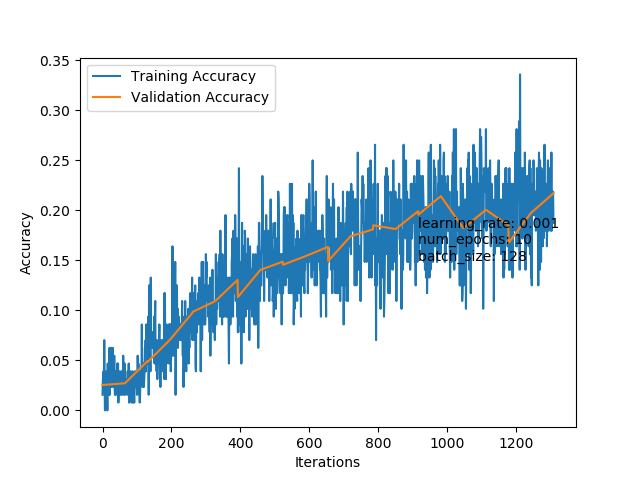

In [18]:
# Plot 
plt.plot(*zip(*sorted(accuracies_train.items())), label="Training Accuracy")
plt.plot(*zip(*sorted(accuracies_test.items())), label="Validation Accuracy")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")

plt.text(0.7 * len(accuracies_train),0.15, "learning_rate: {} \nnum_epochs: {} \nbatch_size: {}".format(learning_rate, epochs, batch_size))

plt.legend()